In [1]:
import networkx as nx
from networkx.algorithms import tree
from tools import dependency, sentence_attentions
from tools.dependency_converter import DependencyConverter


import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np

from itertools import cycle, islice

from tqdm import tqdm

%matplotlib inline

In [16]:
dev = False
if dev:
    attention_file = '../BertAA/BertAA-dev/attentions.npz'
    token_file = '../BertAA/BertAA-dev/source.txt'
    conllu_file_name = '../graph-extraction/endev.conllu'
    no_softmax = False
else:
    attention_file = '../BertAA/attentions.npz'
    token_file = '../BertAA/source.txt'
    conllu_file_name = '../data/entest.conllu'
    no_softmax = True
    

In [17]:
maxlen = 1000

fontsize=8

#this is necessary in this case
eos =True



dependency_rels = dependency.read_conllu_labeled(conllu_file_name)


dependency_rels = [DependencyConverter(sent_rel).convert(return_root=True) for sent_rel in dependency_rels]

with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]
    
attentions_loaded = np.load(attention_file)
sentences_count = 1000
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]

tokens_grouped, common_tokens = dependency.group_wordpieces(tokens_loaded, conllu_file_name)

In [18]:
dependency_rels[71]

[(0, 6, 'nsubj', 'PROPN'),
 (1, 2, 'punct', 'PUNCT'),
 (2, 0, 'conj', 'PRON'),
 (3, 5, 'cc', 'CCONJ'),
 (4, 5, 'nmod:poss', 'PRON'),
 (5, 0, 'conj', 'NOUN'),
 (6, -1, 'root', 'VERB'),
 (7, 6, 'advmod', 'ADV'),
 (8, 6, 'punct', 'PUNCT')]

##  Plot graphs

In [19]:
def draw_graphs(layers, heads, threshold,  sentence):
    sentences = [sentence]
    attention_gen = sentence_attentions.generate_matrices(attentions_loaded, tokens_grouped, eos, no_softmax, maxlen,sentences)
    #attention_gen = enumerate(attention_gen)

    viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}
    
    sentence_index = sentence
    matrices = viss[sentence_index]

    words_list = common_tokens[sentence_index]
    words = ' '.join(words_list)

    edge_labeled = {(d, h) : l for d, h, l, p in dependency_rels[sentence_index] if l != 'root'}

    print(sentence_index)
    print(words)

    DG=nx.DiGraph()
    DG.add_edges_from(edge_labeled.keys())

    labels = {}
    for node in DG.nodes():
        labels[node] = words_list[node]
    posG = nx.spring_layout(DG)

    aggr_matrix = np.mean(np.array(matrices)[layers,heads,:,:], axis=0)

    AG = nx.from_numpy_matrix(aggr_matrix, parallel_edges=True, create_using=nx.DiGraph)

    elarge = [(u, v) for (u, v, d) in AG.edges(data=True) if d['weight'] > threshold]
    weights = [AG[u][v]['weight'] *10 for u,v in elarge]
    posA = nx.spring_layout(AG)



    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))


    nx.draw_networkx_nodes(DG, posG, ax=ax1)
    nx.draw_networkx_edges(DG, posG, ax=ax1)
    nx.draw_networkx_labels(DG, posG,labels, font_size=12, ax=ax1)
    nx.draw_networkx_edge_labels(DG,posG,edge_labels= edge_labeled, font_size=8,font_color='red', ax=ax1)

    nx.draw_networkx_nodes(AG, posA, ax=ax2)
    nx.draw_networkx_edges(AG, posA,edgelist=elarge,  alpha=0.5, width=weights, ax=ax2)
    nx.draw_networkx_labels(AG, posA,labels, font_size=12, ax=ax2)


    plt.show()

In [20]:
def draw_spanning_trees(layers, heads, sentence, transpose=True):
    sentences = [sentence]
    attention_gen = sentence_attentions.generate_matrices(attentions_loaded, tokens_grouped, eos, no_softmax, maxlen,sentences)
    #attention_gen = enumerate(attention_gen)

    viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}
    
    sentence_index = sentence
    matrices = viss[sentence_index]

    words_list = common_tokens[sentence_index]
    words = ' '.join(words_list)

    edge_labeled = {(d, h) : l for d, h, l, p in dependency_rels[sentence_index] if l != 'root'}

    DG=nx.DiGraph()
    DG.add_edges_from(edge_labeled.keys())

    labels = {}
    for node in DG.nodes():
        labels[node] = words_list[node]
    posG = nx.spring_layout(DG)

    aggr_matrix = np.mean(np.array(matrices)[layers,heads,:,:], axis=0)
    if transpose:
        aggr_matrix = aggr_matrix.transpose()
    AG = nx.from_numpy_matrix(aggr_matrix, parallel_edges=True, create_using=nx.Graph)

    espanning = list(tree.maximum_spanning_edges(AG.to_undirected(),data=True))
    print(espanning)
    weights = [d['weight'] *10 for _,_,d in espanning]
    espanning = [(u, v) for (u, v, d) in espanning]
    posA = nx.spring_layout(AG)



    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))


    nx.draw_networkx_nodes(DG, posG, ax=ax1)
    nx.draw_networkx_edges(DG, posG, ax=ax1)
    nx.draw_networkx_labels(DG, posG,labels, font_size=12, ax=ax1)
    nx.draw_networkx_edge_labels(DG,posG,edge_labels= edge_labeled, font_size=8,font_color='red', ax=ax1)

    nx.draw_networkx_nodes(AG, posA, ax=ax2)
    nx.draw_networkx_edges(AG, posA,edgelist=espanning,  alpha=0.5, width=weights, ax=ax2)
    nx.draw_networkx_labels(AG, posA,labels, font_size=12, ax=ax2)


    plt.show()

## Multigraphs

In [21]:
all_pos = set()
for sent_rels in dependency_rels:
    for dep, head, label, pos in sent_rels:
        all_pos.add(pos)

In [22]:
def pos_dict():
    all_pos = {'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN','NUM',
    'PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X'}
    
    res_dict = dict()
    for pos1 in all_pos:
        for pos2 in all_pos:
            res_dict[(pos1,pos2)] = 0
    return res_dict

In [23]:
from collections import namedtuple, defaultdict
import pandas as pd


RelData= namedtuple('RelData','layers heads transpose d2p')

relation_rules = {'nsubj': RelData([4,7,8], [10, 11, 10], False, False),
                  'obj': RelData([7, 6, 3, 6, 4, 6, 5],[ 9,  9, 11, 10,  6,  3,  3], False, True),
                  'amod': RelData([3, 7, 6, 5, 8, 0, 2], [ 9, 10,  5,  7,  5,  8, 11], True, True),
                  'aux': RelData([3, 7, 8, 5, 4, 7, 0],[ 9,  6,  5,  0,  5, 10,  8], True,True),
                  'det': RelData([7, 3, 4, 8], [10,  9,  5, 10], True, True)
                 }


dependency_pos_freq = defaultdict(lambda: pos_dict())
for sent_rels in dependency_rels:
    for dep, head, label, pos in sent_rels:
        if label != 'root':
            pos_pair = (pos, sent_rels[head][3])
            dependency_pos_freq[label][pos_pair] += 1
            
            
pos_frame = pd.DataFrame.from_dict(dependency_pos_freq)
pos_frame = pos_frame / pos_frame.sum(axis=1)[:,None]
pos_frame.fillna(0, inplace=True)

In [10]:
def multigraph_trees(sentence):
    sentences = [sentence]
    attention_gen = sentence_attentions.generate_matrices(attentions_loaded, tokens_grouped, eos, no_softmax, maxlen,sentences)
    #attention_gen = enumerate(attention_gen)

    viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}
    

    sentence_index = sentence
    matrices = viss[sentence_index]

    words_list = common_tokens[sentence_index]
    words = ' '.join(words_list)
    
    print(words)
    
    edge_labeled = {(d, h) : l for d, h, l, p in dependency_rels[sentence_index] if l != 'root'}
    token2pos = {d : p for d, h, l, p in dependency_rels[sentence_index]}
    DG=nx.DiGraph()
    DG.add_edges_from(edge_labeled.keys())
    
    labels = {}
    for node in DG.nodes():
        labels[node] = words_list[node]
    posG = nx.spring_layout(DG)


    MultiAttention = nx.MultiGraph()
    MultiAttention.add_nodes_from(DG.nodes())

    for relation, rules in relation_rules.items():
        aggr_matrix = np.mean(np.array(matrices)[rules.layers,rules.heads,:,:], axis=0)
        for i in range(len(aggr_matrix)):
            for j in range(len(aggr_matrix)):
                if i!=j:
                    if rules.d2p:
                        aggr_matrix[i,j] *= pos_frame[relation][token2pos[i]][token2pos[j]]

                    else:
                        aggr_matrix[i,j] *= pos_frame[relation][token2pos[j]][token2pos[i]]

        if rules.transpose:
            aggr_matrix = aggr_matrix.transpose()
        AG = nx.from_numpy_matrix(aggr_matrix, create_using=nx.Graph)
        # incldue statistical info about pos:

        MultiAttention.add_edges_from(AG.edges(data=True), label=relation)

    espanning = list(tree.branchings.maximum_spanning_edges(MultiAttention,data=True))
    print(espanning)
    weights = [d['weight'] *10 for _,_,_,d in espanning]
    attention_labels  = {(u,v) : d['label'] for u,v,_,d in espanning}
    espanning = [(u, v) for (u, v,l, d) in espanning]
    posA = nx.spring_layout(MultiAttention)

    



    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))


    nx.draw_networkx_nodes(DG, posG, ax=ax1)
    nx.draw_networkx_edges(DG, posG, ax=ax1)
    nx.draw_networkx_labels(DG, posG,labels, font_size=12, ax=ax1)
    nx.draw_networkx_edge_labels(DG,posG,edge_labels= edge_labeled, font_size=8,font_color='red', ax=ax1)

    nx.draw_networkx_nodes(MultiAttention, posA, ax=ax2)
    nx.draw_networkx_edges(MultiAttention, posA,edgelist=espanning,  alpha=0.5,width=weights, ax=ax2)
    nx.draw_networkx_edge_labels(MultiAttention,posA,edge_labels=attention_labels,
                                 font_color='green',font_size=8, ax=ax2)
    nx.draw_networkx_labels(MultiAttention, posA,labels, font_size=12, ax=ax2)


    plt.show()

## Multigraph aborescene

## Visualizations

1it [00:00,  4.16it/s]


the last speaker addressed some of the points that i would wish to make .
[(0, 2, 0, {'label': 'det', 'weight': 0.6789675163309876}), (2, 1, 1, {'label': 'amod', 'weight': 0.6002781533787392}), (9, 10, 0, {'label': 'nsubj', 'weight': 0.5530813116776315}), (7, 6, 0, {'label': 'det', 'weight': 0.5204155938818701}), (4, 7, 0, {'label': 'det', 'weight': 0.4337497552563105}), (11, 9, 0, {'label': 'nsubj', 'weight': 0.3113440576652602}), (9, 13, 0, {'label': 'nsubj', 'weight': 0.3031162095639944}), (3, 4, 1, {'label': 'obj', 'weight': 0.1704989346590909}), (6, 8, 0, {'label': 'det', 'weight': 0.1580657958984375}), (8, 13, 0, {'label': 'nsubj', 'weight': 0.13133666820499296}), (0, 3, 0, {'label': 'nsubj', 'weight': 0.055294152462121215}), (9, 14, 0, {'label': 'obj', 'weight': 0.032856532505580356}), (5, 7, 0, {'label': 'nsubj', 'weight': 0.01003265380859375})]


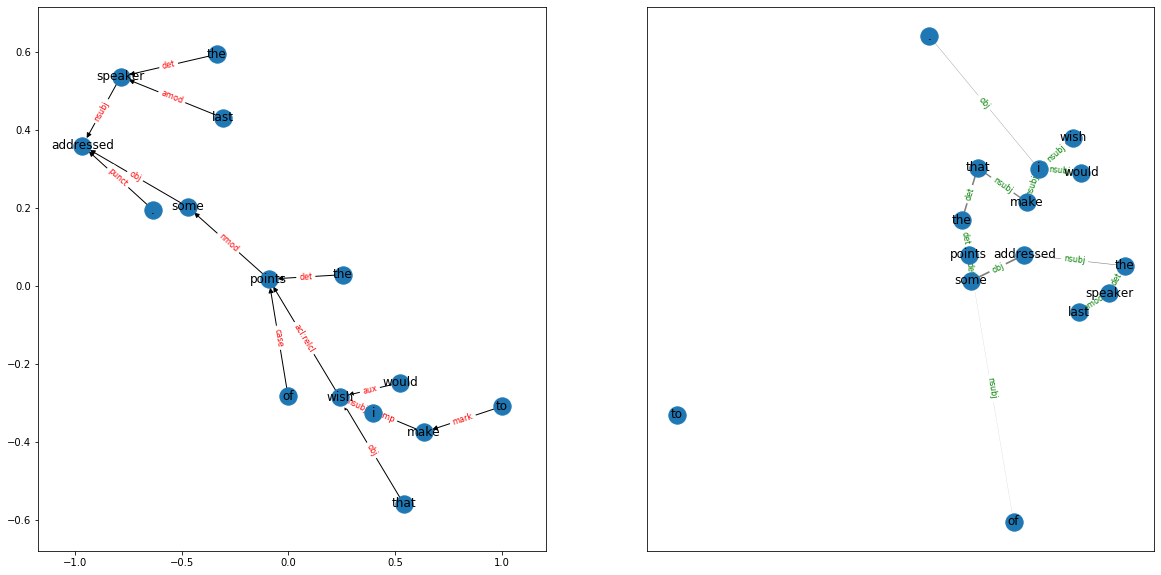

In [25]:
multigraph_trees(445)

In [26]:
sentences = [344]
attention_gen = sentence_attentions.generate_matrices(attentions_loaded, tokens_grouped, eos, no_softmax, maxlen,sentences)
#attention_gen = enumerate(attention_gen)

viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}

1it [00:00,  5.43it/s]


### Subjects

1it [00:00,  3.18it/s]
/ha/home/limisiewicz/.virtualenvs/general/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/ha/home/limisiewicz/.virtualenvs/general/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


257
those who are competent among us and responsible enough to solve their own problems are , we believe , the people themselves .


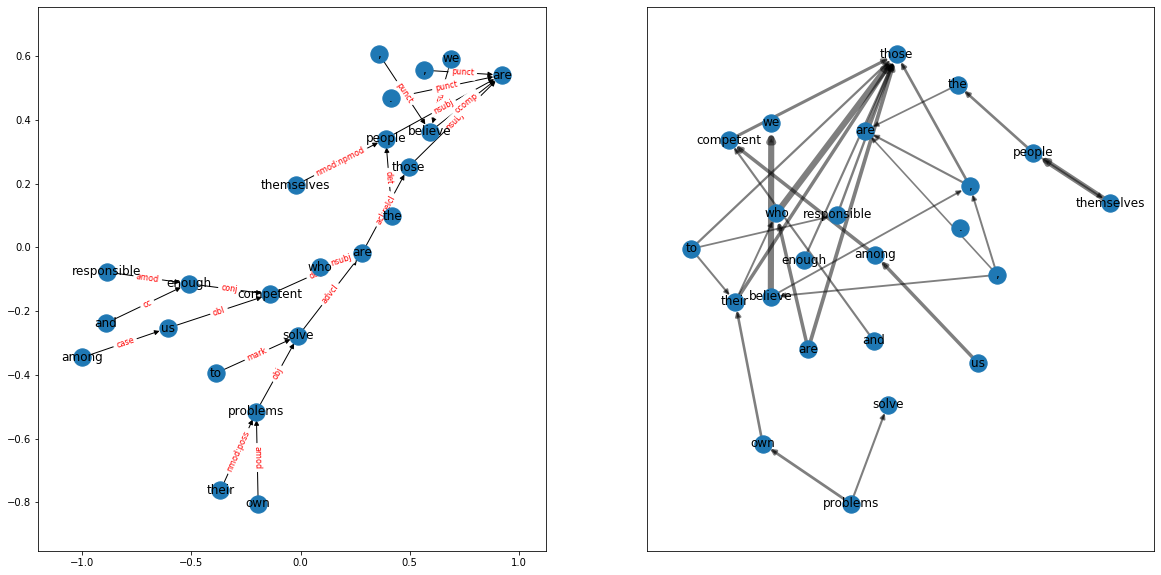

In [27]:
l = [4,7,8]
h = [10, 11, 10]
sentences = draw_graphs(l,h,0.15,257)

1it [00:00,  4.43it/s]
/ha/home/limisiewicz/.virtualenvs/general/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/ha/home/limisiewicz/.virtualenvs/general/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


[(10, 11, {'weight': 0.78466796875}), (0, 1, {'weight': 0.7486979166666666}), (0, 2, {'weight': 0.5738932291666666}), (10, 12, {'weight': 0.44873046875}), (0, 9, {'weight': 0.3854166666666667}), (0, 8, {'weight': 0.3720499674479167}), (0, 4, {'weight': 0.2916768391927083}), (3, 4, {'weight': 0.2898152669270833}), (0, 5, {'weight': 0.2731730143229167}), (0, 6, {'weight': 0.2552083333333333}), (0, 7, {'weight': 0.24363199869791666}), (0, 13, {'weight': 0.15867106119791666}), (9, 10, {'weight': 0.14088948567708334})]


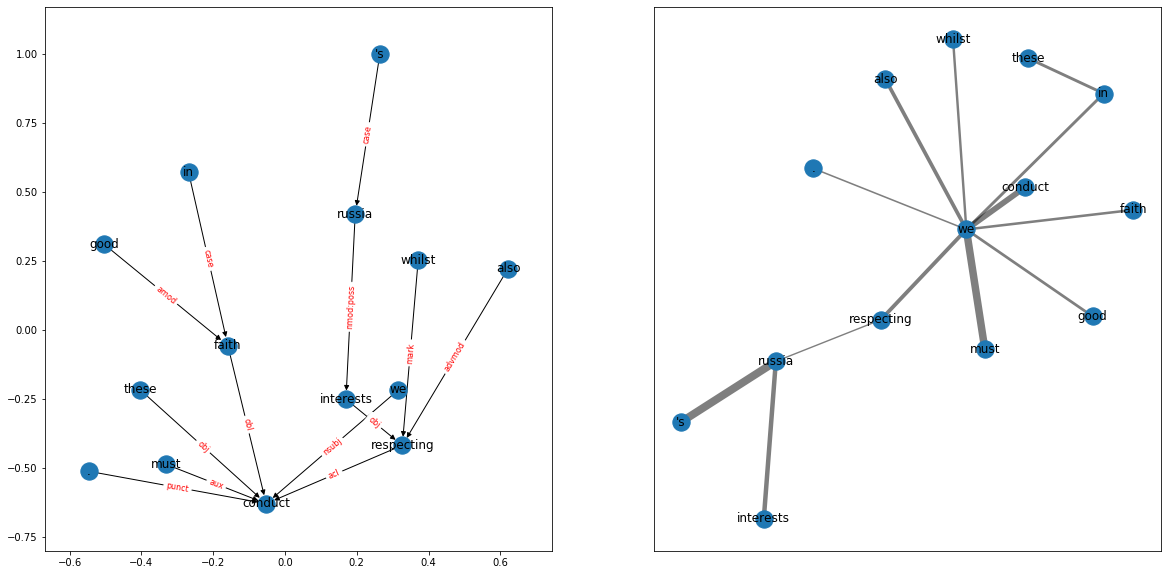

In [31]:
l = [4,7,8]
h = [10, 11, 10]
sentences = draw_spanning_trees(l,h,69, transpose=False)

### Objects

1it [00:00,  2.34it/s]


445
for the commission , an essential move to achieve those aims is to reinforce the role of the key bodies in these fields , but at european and at international level .


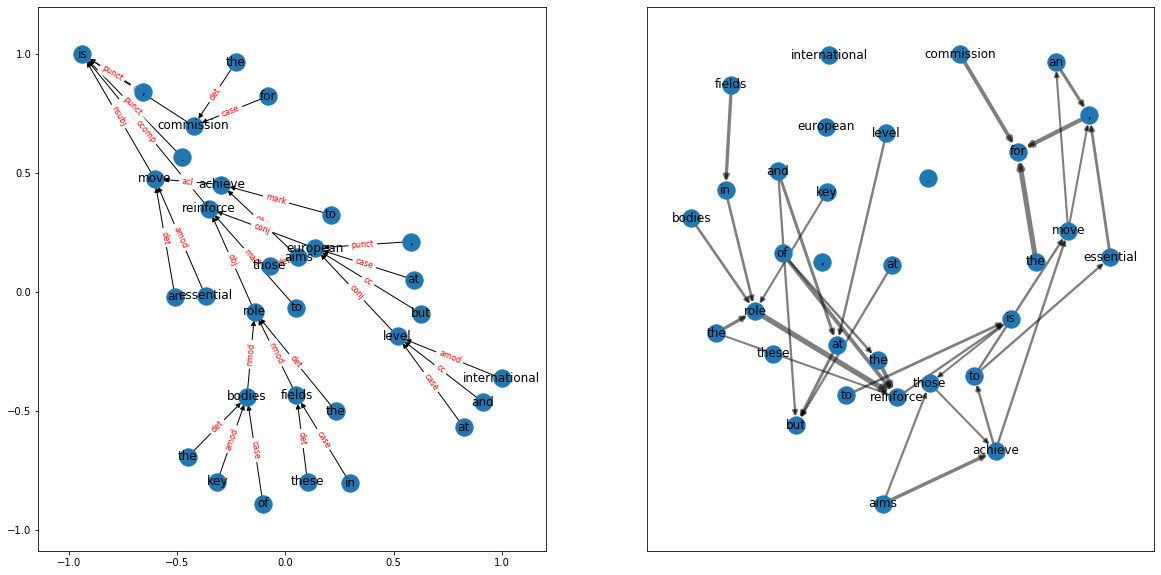

In [36]:
l = [7, 6, 3, 6, 4, 5, 3]
h = [ 9,  9, 11, 10,  6,  3,  8]
sentences = draw_graphs(l,h,0.2,445)

1it [00:00,  4.38it/s]


[(3, 5, {'weight': 0.4652186802455357}), (3, 6, {'weight': 0.38480922154017855}), (3, 4, {'weight': 0.3761509486607143}), (0, 1, {'weight': 0.33748953683035715}), (3, 7, {'weight': 0.30789620535714285}), (1, 2, {'weight': 0.300048828125}), (11, 12, {'weight': 0.27239990234375}), (1, 3, {'weight': 0.261199951171875}), (3, 8, {'weight': 0.2566866193498884}), (8, 10, {'weight': 0.25348336356026785}), (8, 13, {'weight': 0.22160121372767858}), (8, 11, {'weight': 0.21334402901785715}), (3, 9, {'weight': 0.19492449079241073}), (7, 14, {'weight': 0.14689200265066965})]


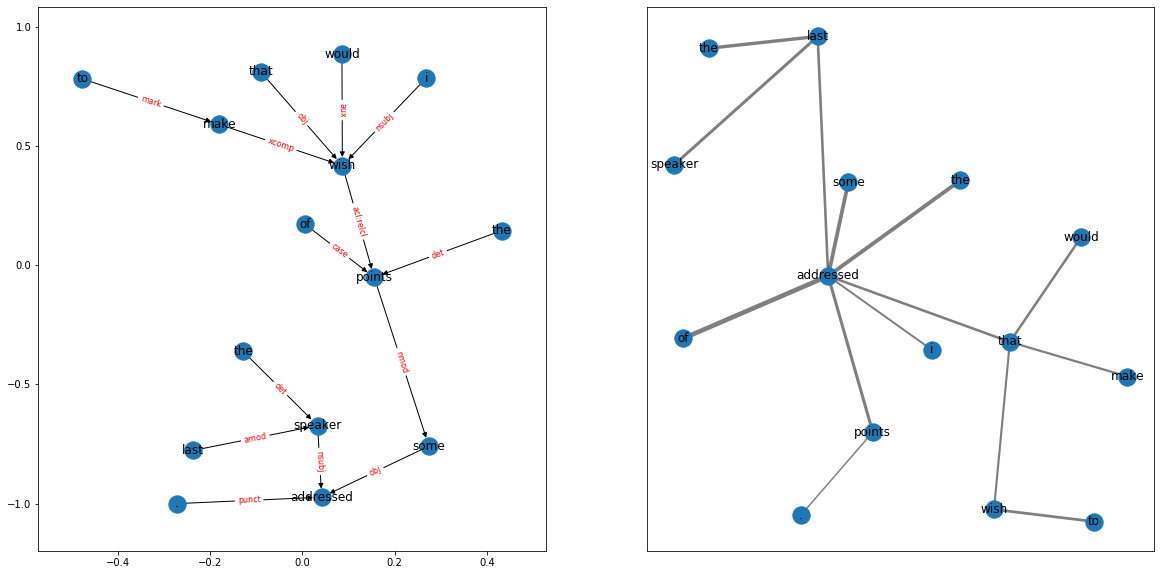

In [35]:
l = [7, 6, 3, 6, 4, 5, 3]
h = [ 9,  9, 11, 10,  6,  3,  8]
sentences = draw_spanning_trees(l,h,445, transpose=False)

### Detrminers

1it [00:00,  4.00it/s]


745
approximately 10 - 12 million roma reside in the european union .


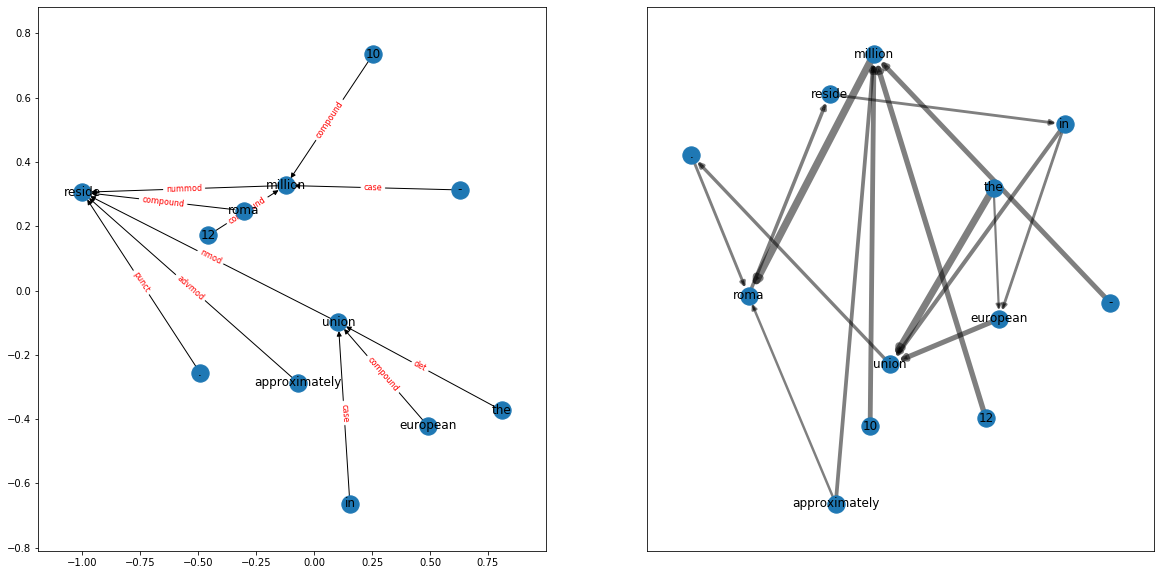

In [9]:
l = [7, 3, 4, 8]
h  = [10,  9,  5, 10]
sentences = draw_graphs(l,h,0.2,745)

1it [00:00,  4.54it/s]


[(11, 12, {'weight': 0.8221435546875}), (3, 5, {'weight': 0.66705322265625}), (4, 5, {'weight': 0.5466461181640625}), (0, 5, {'weight': 0.5291748046875}), (10, 12, {'weight': 0.52581787109375}), (1, 5, {'weight': 0.495635986328125}), (7, 8, {'weight': 0.48969268798828125}), (6, 8, {'weight': 0.48077392578125}), (12, 13, {'weight': 0.34903717041015625}), (8, 10, {'weight': 0.34197998046875}), (2, 5, {'weight': 0.33355712890625}), (9, 12, {'weight': 0.3260345458984375}), (5, 6, {'weight': 0.2721099853515625})]


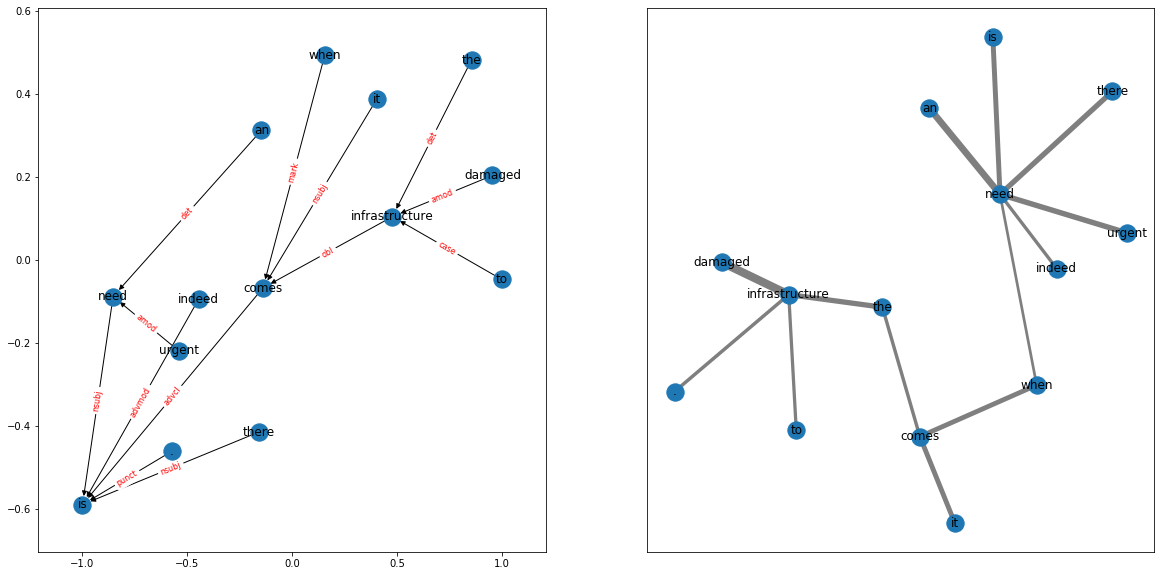

In [41]:
l = [7, 3, 4, 8]
h  = [10,  9,  5, 10]
sentences = draw_spanning_trees(l,h,745, transpose=True)

### Adjective modifier

1it [00:00,  3.41it/s]


118
well , increasing numbers of british people are demanding that we come out of it .


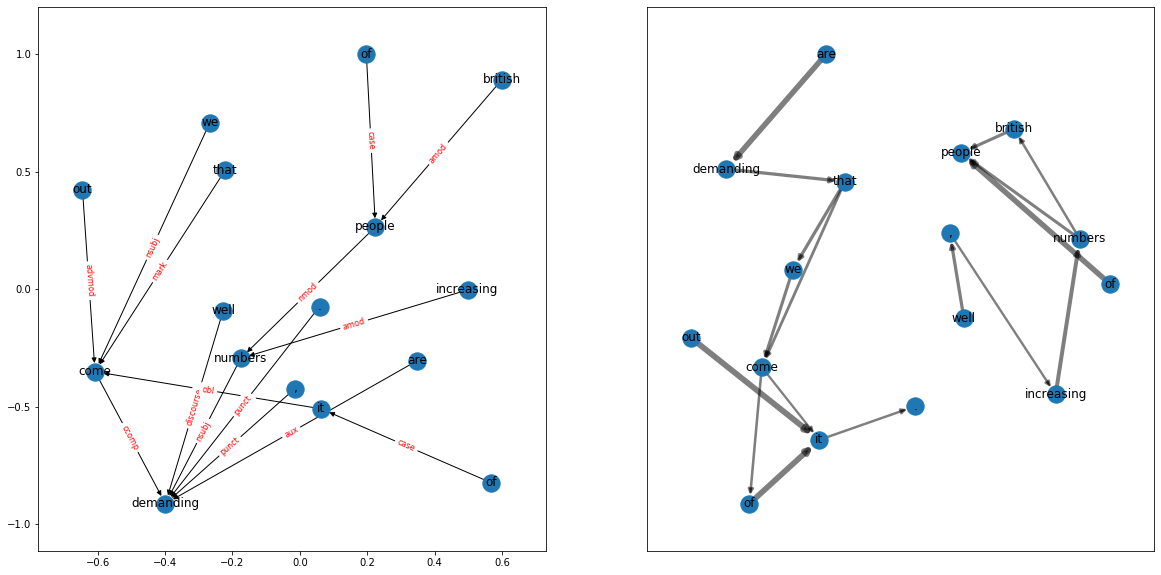

In [45]:
l = [3, 7, 5, 8, 7, 0]
h  = [ 9, 10,  7,  5,  6,  8]
sentences = draw_graphs(l,h,0.2,118)

1it [00:00,  4.23it/s]


[(12, 14, {'weight': 0.5799560546875}), (13, 14, {'weight': 0.5683085123697916}), (7, 8, {'weight': 0.548309326171875}), (4, 6, {'weight': 0.54193115234375}), (2, 3, {'weight': 0.3994547526041667}), (0, 1, {'weight': 0.3252716064453125}), (9, 10, {'weight': 0.32476806640625}), (8, 9, {'weight': 0.3242289225260417}), (5, 6, {'weight': 0.3103230794270833}), (10, 11, {'weight': 0.3077392578125}), (3, 6, {'weight': 0.3057454427083333}), (11, 13, {'weight': 0.25675201416015625}), (14, 15, {'weight': 0.2483800252278646}), (1, 2, {'weight': 0.23555501302083334}), (6, 8, {'weight': 0.19345601399739584})]


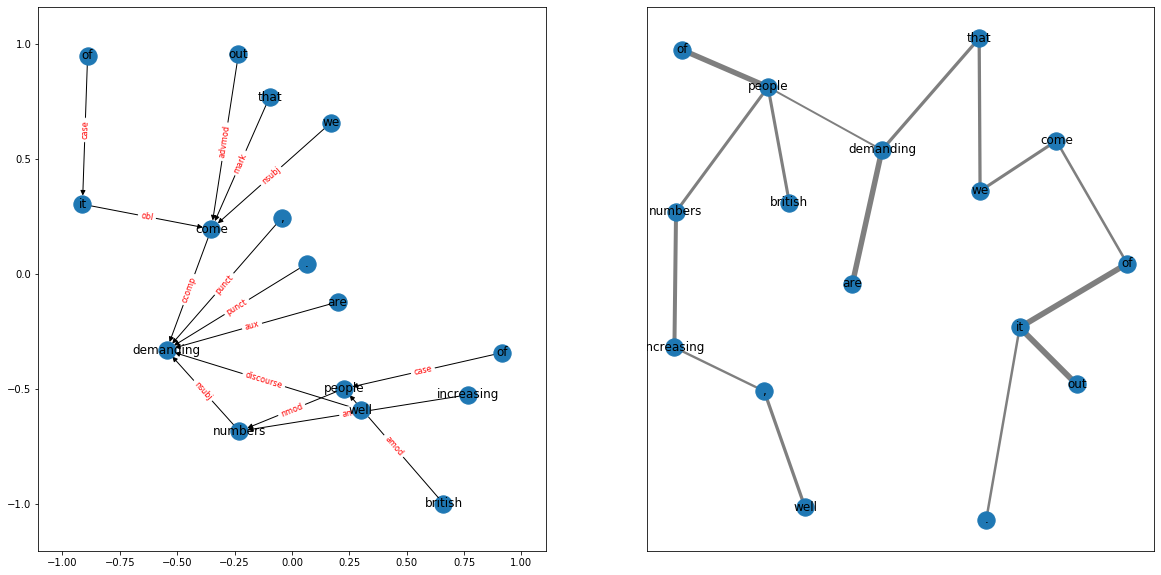

In [48]:
l = [3, 7, 5, 8, 7, 0]
h  = [ 9, 10,  7,  5,  6,  8]
sentences = draw_spanning_trees(l,h,118, transpose=True)

# All

1it [00:00,  1.08it/s]


149
in accordance with the principle of reciprocity , the eu considers that , in the case of nationals from third countries who are exempted from the visa requirement for travelling to the eu member states , the third country should provide reciprocal treatment for the eu citizens by exempting them from the visa requirement when travelling to that country .


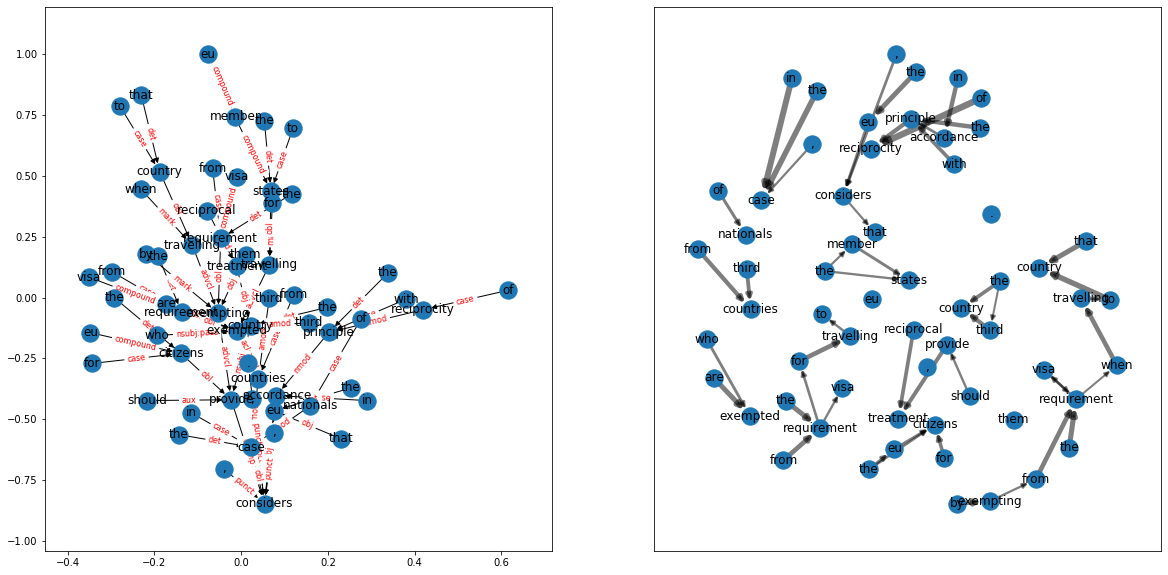

In [11]:
l = [3, 7, 6, 8, 4, 3, 0, 0]
h  = [ 9, 10,  5,  5,  5, 10,  8, 11]
sentences = draw_graphs(l,h,0.2,149)